In [83]:
import numpy as np
import pandas as pd
import librosa 
import librosa.display
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn import metrics 


In [114]:
fulldatasetpath = 'P:\Study\Phonemes Classification\TIMIT dataset'
train_dir = os.path.join(fulldatasetpath, 'data\TRAIN')
test_dir = os.path.join(fulldatasetpath, 'data\TEST')
train_dir

'P:\\Study\\Phonemes Classification\\TIMIT dataset\\data\\TRAIN'

In [3]:
pd.read_csv(os.path.join(fulldatasetpath, 'train_data.csv'))

,index,test_or_train,dialect_region,speaker_id,filename,path_from_data_dir,path_from_data_dir_windows,is_converted_audio,is_audio,is_word_file,is_phonetic_file,is_sentence_file
0,1,TRAIN,DR4,MMDM0,SI681.WAV.wav,TRAIN/DR4/MMDM0/SI681.WAV.wav,TRAIN\\DR4\\MMDM0\\SI681.WAV.wav,True,True,False,False,False
1,2,TRAIN,DR4,MMDM0,SI1311.PHN,TRAIN/DR4/MMDM0/SI1311.PHN,TRAIN\\DR4\\MMDM0\\SI1311.PHN,False,False,False,True,False
2,3,TRAIN,DR4,MMDM0,SI1311.WRD,TRAIN/DR4/MMDM0/SI1311.WRD,TRAIN\\DR4\\MMDM0\\SI1311.WRD,False,False,True,False,False
3,4,TRAIN,DR4,MMDM0,SX321.PHN,TRAIN/DR4/MMDM0/SX321.PHN,TRAIN\\DR4\\MMDM0\\SX321.PHN,False,False,False,True,False
4,5,TRAIN,DR4,MMDM0,SX321.WRD,TRAIN/DR4/MMDM0/SX321.WRD,TRAIN\\DR4\\MMDM0\\SX321.WRD,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
23095,23096,TRAIN,DR8,MRDM0,SI1044.WAV.wav,TRAIN/DR8/MRDM0/SI1044.WAV.wav,TRAIN\\DR8\\MRDM0\\SI1044.WAV.wav,True,True,False,NaN,False
23096,23097,TRAIN,DR8,MRDM0,SX245.WAV,TRAIN/DR8/MRDM0/SX245.WAV,TRAIN\\DR8\\MRDM0\\SX245.WAV,False,True,False,NaN,False
23097,23098,TRAIN,DR8,MRDM0,SA2.WAV.wav,TRAIN/DR8/MRDM0/SA2.WAV.wav,TRAIN\\DR8\\MRDM0\\SA2.WAV.wav,True,True,False,NaN,False
23098,23099,TRAIN,DR8,MRDM0,SX335.WAV,TRAIN/DR8/MRDM0/SX335.WAV,TRAIN\\DR8\\MRDM0\\SX335.WAV,False,True,False,NaN,False


In [11]:
files = [f for f in os.listdir(os.path.join(train_dir, 'DR1/FCJF0'))
             if os.path.isfile(os.path.join(train_dir, 'DR1/FCJF0', f))]

In [12]:
examples = [x[:-4] for x in files if x[-3:] != 'wav']
examples = np.unique(np.array(examples))

In [115]:
def get_example_data(wav_file, phn_file):
    max_pad_len = 39
    result = []
#     try:
        audio, sample_rate = librosa.load(wav_file, res_type='kaiser_fast', sr=None) 
        phonemesdf = pd.read_csv(phn_file, sep=' ', names=['begin', 'end', 'phoneme'])

        for index, row in phonemesdf.iterrows():
            phoneme = row['phoneme']
            if phoneme == 'h#':
                continue
            phoneme_audio = audio[row['begin']:row['end']].copy()
            mfccs = librosa.feature.mfcc(y=phoneme_audio, sr=sample_rate, n_mfcc=40, n_fft=64)
#             if (max_pad_len - mfccs.shape[1]) % 2 == 1:
#                 paddings = tf.constant([[0, 0,], [(max_pad_len - mfccs.shape[1]) // 2, (max_pad_len - mfccs.shape[1]) // 2 + 1]])
#             else:
#                 paddings = tf.constant([[0, 0,], [(max_pad_len - mfccs.shape[1]) // 2, (max_pad_len - mfccs.shape[1]) // 2]])
#             mfccs = np.pad(mfccs, paddings, mode='constant')
            result.append([mfccs, phoneme])

    except Exception as e:
        print("Error encountered while parsing file: ", wav_file)
    return result

even
16000
(40, 9)
eh
[[ 0.0000000e+00  0.0000000e+00 -3.9903070e+02 -3.7307910e+02
  -3.9011844e+02 -4.1976645e+02 -4.6097198e+02  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  9.8983810e+01  2.7925373e+01
   1.2712124e+01  2.0903782e+01  7.9020416e+01  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.0028634e+00 -8.3882187e+01
  -8.2938789e+01 -5.6971397e+01 -8.9161339e+00  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  4.2756710e+01  7.1156964e+00
   6.3380060e+00  1.0858566e+01  1.6603168e+01  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.7997108e+01 -6.1324104e+01
  -6.2433456e+01 -5.2345875e+01 -3.1862820e+01  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -3.6598244e+00 -5.0669693e+01
  -4.7773865e+01 -4.7281555e+01 -3.9258698e+01  0.0000000e+00
   0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  2.0890570e-01 -1.7984615e+01
  -1.6568098e+01 -1.3690018e+01 -1.9672501e+01  0.0000000e+00
  

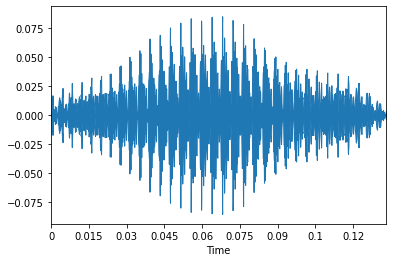

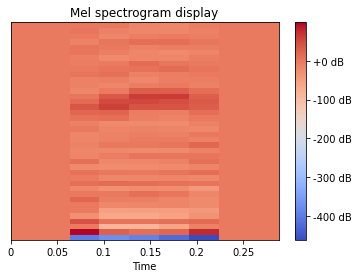

In [106]:
index = 4
max_pad_len = 9
# wav_file = os.path.join(train_dir, 'DR1/FCJF0/SA1.WAV')
wav_file = os.path.join(train_dir, 'DR1/FCJF0/SA1.WAV')
phn_file = os.path.join(train_dir, 'DR1/FCJF0/SA1.PHN')
phonemesdf = pd.read_csv(phn_file, sep=' ', names=['begin', 'end', 'phoneme'])
audio, sample_rate = librosa.load(wav_file, res_type='kaiser_fast', sr=None)
phoneme_audio = audio[phonemesdf['begin'][index]:phonemesdf['end'][index]]
mfccs = librosa.feature.mfcc(y=phoneme_audio, sr=sample_rate, n_mfcc=40, n_fft=1048)
librosa.display.waveplot(phoneme_audio,sr=sample_rate)
# librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')
if (max_pad_len - mfccs.shape[1]) % 2 == 1:
    paddings = tf.constant([[0, 0,], [(max_pad_len - mfccs.shape[1]) // 2, (max_pad_len - mfccs.shape[1]) // 2 + 1]])
    print('odd')
else:
    paddings = [[0, 0], [(max_pad_len - mfccs.shape[1]) // 2, (max_pad_len - mfccs.shape[1]) // 2]]
    print('even')
mfccs = np.pad(mfccs, paddings, mode='constant')

fig, ax = plt.subplots()
img = librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")

print(sample_rate)
print(mfccs.shape)
print(phonemesdf['phoneme'][index])
print(mfccs)

In [121]:
train_data = []
for dialect in os.listdir(train_dir):
    for reader in os.listdir(os.path.join(train_dir, dialect)):
        files = [f for f in os.listdir(os.path.join(train_dir, dialect, reader))
             if os.path.isfile(os.path.join(train_dir, dialect, reader, f))]
        examples = [x[:-4] for x in files if x[-3:] != 'wav']
        examples = np.unique(np.array(examples))
        
        for ex in examples:
            wav_file = os.path.join(train_dir, dialect, reader, ex + '.WAV')
            phn_file = os.path.join(train_dir, dialect, reader, ex + '.WRD')
            data = get_example_data(wav_file, phn_file)
            train_data += data
            
test_data = []
for dialect in os.listdir(test_dir):
    for reader in os.listdir(os.path.join(test_dir, dialect)):
        files = [f for f in os.listdir(os.path.join(test_dir, dialect, reader))
             if os.path.isfile(os.path.join(test_dir, dialect, reader, f))]
        examples = [x[:-4] for x in files if x[-3:] != 'wav']
        examples = np.unique(np.array(examples))
        
        for ex in examples:
            wav_file = os.path.join(test_dir, dialect, reader, ex + '.WAV')
            phn_file = os.path.join(test_dir, dialect, reader, ex + '.WRD')
            data = get_example_data(wav_file, phn_file)
            test_data += data

Error encountered while parsing file:  P:\Study\Phonemes Classification\TIMIT dataset\data\TRAIN\DR3\MAKR0\SI1982.WAV
Error encountered while parsing file:  P:\Study\Phonemes Classification\TIMIT dataset\data\TRAIN\DR3\MHJB0\SA2.WAV


KeyboardInterrupt: 

In [120]:
print(max([x[0].shape[1] for x in train_data]))
print(max([x[0].shape[1] for x in test_data]))
print(np.unique([x[1] for x in train_data]).shape)
print(np.unique([x[1] for x in test_data]).shape)
print(len(train_data))
print(len(test_data))

52
42
(4889,)
(2378,)
39784
14550


In [18]:
print(type(test_data))
print(type(test_data[0]))
print(type(test_data[0][0]))
print(type(test_data[0][0][0][0]))
print(test_data[0][0].shape)

<class 'list'>
<class 'list'>
<class 'numpy.ndarray'>
<class 'numpy.float32'>
(40, 39)


ValueError: setting an array element with a sequence.

In [98]:
testdf = pd.DataFrame(test_data, columns=['mfccs', 'phoneme'])
traindf = pd.DataFrame(train_data, columns=['mfccs', 'phoneme'])

In [99]:
X_train = np.array(traindf.mfccs.tolist())
y_train = np.array(traindf.phoneme.tolist())
X_test = np.array(testdf.mfccs.tolist())
y_test = np.array(testdf.phoneme.tolist())

le = LabelEncoder()
le.fit(y_train)
le.fit(y_test)
yy_train = to_categorical(le.transform(y_train))
yy_test = to_categorical(le.transform(y_test))



In [63]:
print(type(X_train))
print(X_train.shape)
print(type(X_train[0]))
print(np.unique(y_train))
print(np.unique(y_train).shape)

<class 'numpy.ndarray'>
(167840, 40, 39)
<class 'numpy.ndarray'>
['aa' 'ae' 'ah' 'ao' 'aw' 'ax' 'ax-h' 'axr' 'ay' 'b' 'bcl' 'ch' 'd' 'dcl'
 'dh' 'dx' 'eh' 'el' 'em' 'en' 'eng' 'epi' 'er' 'ey' 'f' 'g' 'gcl' 'hh'
 'hv' 'ih' 'ix' 'iy' 'jh' 'k' 'kcl' 'l' 'm' 'n' 'ng' 'nx' 'ow' 'oy' 'p'
 'pau' 'pcl' 'q' 'r' 's' 'sh' 't' 'tcl' 'th' 'uh' 'uw' 'ux' 'v' 'w' 'y'
 'z' 'zh']
(60,)


In [100]:
num_rows = 40
num_columns = 39
num_channels = 1

x_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
x_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

num_labels = yy_train.shape[1]
filter_size = 2

norm_layer = preprocessing.Normalization()
norm_layer.adapt(x_train)

# Construct model 
model = Sequential([
    Input(shape=(num_rows, num_columns, num_channels)),
    norm_layer,
    Conv2D(filters=16, kernel_size=2, #input_shape=(num_rows, num_columns, num_channels),
           activation='relu'),
    MaxPooling2D(pool_size=2),
    Dropout(0.2),
    Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    Dropout(0.2),
    Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    Dropout(0.2),
    Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_labels, activation='softmax')
])


In [101]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [102]:
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, yy_test, verbose=1)
accuracy = score[1]

print("Pre-training accuracy: {acc:f}".format(acc=accuracy))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 40, 39, 1)         3         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 39, 38, 16)        80        
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 19, 19, 16)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 19, 19, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 19, 19, 32)        2080      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 9, 9, 32)          0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 9, 9, 32)         

In [103]:
num_epochs = 50
num_batch_size = 256

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(x_train, yy_train, batch_size=num_batch_size, epochs=num_epochs, 
          validation_data=(x_test, yy_test), callbacks=[checkpointer], verbose=1)


Epoch 1/50
656/656 [==============================] - 14s 20ms/step - loss: 2.8797 - accuracy: 0.1933 - val_loss: 2.4324 - val_accuracy: 0.2818

Epoch 00001: val_loss improved from inf to 2.43237, saving model to saved_models\weights.best.basic_cnn.hdf5
Epoch 2/50
656/656 [==============================] - 13s 20ms/step - loss: 2.4470 - accuracy: 0.2710 - val_loss: 2.3494 - val_accuracy: 0.3099

Epoch 00002: val_loss improved from 2.43237 to 2.34943, saving model to saved_models\weights.best.basic_cnn.hdf5
Epoch 3/50
656/656 [==============================] - 13s 20ms/step - loss: 2.3305 - accuracy: 0.3000 - val_loss: 2.2527 - val_accuracy: 0.3226

Epoch 00003: val_loss improved from 2.34943 to 2.25267, saving model to saved_models\weights.best.basic_cnn.hdf5
Epoch 4/50
656/656 [==============================] - 13s 20ms/step - loss: 2.2712 - accuracy: 0.3146 - val_loss: 2.2407 - val_accuracy: 0.3275

Epoch 00004: val_loss improved from 2.25267 to 2.24071, saving model to saved_models\


Epoch 00039: val_loss did not improve from 2.03214
Epoch 40/50
656/656 [==============================] - 13s 20ms/step - loss: 2.0101 - accuracy: 0.3790 - val_loss: 2.0872 - val_accuracy: 0.3631

Epoch 00040: val_loss did not improve from 2.03214
Epoch 41/50
656/656 [==============================] - 13s 20ms/step - loss: 2.0079 - accuracy: 0.3788 - val_loss: 2.0553 - val_accuracy: 0.3723

Epoch 00041: val_loss did not improve from 2.03214
Epoch 42/50
656/656 [==============================] - 13s 20ms/step - loss: 2.0074 - accuracy: 0.3795 - val_loss: 2.0854 - val_accuracy: 0.3673

Epoch 00042: val_loss did not improve from 2.03214
Epoch 43/50
656/656 [==============================] - 13s 20ms/step - loss: 2.0056 - accuracy: 0.3798 - val_loss: 2.0531 - val_accuracy: 0.3696

Epoch 00043: val_loss did not improve from 2.03214
Epoch 44/50
656/656 [==============================] - 13s 20ms/step - loss: 2.0024 - accuracy: 0.3814 - val_loss: 2.0995 - val_accuracy: 0.3633

Epoch 00044: v